In [1]:
# Date : 27-05-2024
# Author : DAS
# DATA : OLLIES
# PROJECT : MMM
import pandas as pd
import numpy as np
from prophet import Prophet
from pymc_marketing.mmm import DelayedSaturatedMMM
import pymc as pm
import arviz as az

In [2]:
from google.cloud import bigquery
bigquery_client = bigquery.Client()

In [3]:
# IMport sales data:
QUERY = """ 
        select * from zai-mlops-sandbox.zAI_OLLI.Z_OLLIES_MMM_pivot
        """

In [4]:
#Run the query and write result to a pandas data frame
Query_Results = bigquery_client.query(QUERY)
sales_df = Query_Results.to_dataframe()
sales_df.head(5)

Date     Revenue        META_S     META_I  TikTok_S  TikTOk_I  \
0  2024-02-01  4595511.00   4557.879999  2488320.0       0.0       0.0   
1  2024-02-02  5702035.90  12014.990000  5881662.0       0.0       0.0   
2  2024-02-03  8049132.14  13215.719998  6499233.0       0.0       0.0   
3  2024-02-04  5016905.50   7138.799998  4032776.0       0.0       0.0   
4  2024-02-05  3821767.81   4392.399999  2698146.0       0.0       0.0   

       Search_S    Search_I  OLV_S  OLV_I  CTV_S  CTV_I  Display_S  Display_I  
0   5398.705116  19421454.0    0.0    0.0    0.0    0.0        0.0        0.0  
1   9466.395597  11121402.0    0.0    0.0    0.0    0.0        0.0        0.0  
2  11174.482018   9218305.0    0.0    0.0    0.0    0.0        0.0        0.0  
3   6370.810997  16547554.0    0.0    0.0    0.0    0.0        0.0        0.0  
4  10931.013103  23167205.0    0.0    0.0    0.0    0.0        0.0        0.0

In [6]:
ollie_df = sales_df.copy()
ollie_df.to_csv("ollies_data.csv")

In [7]:
ollie_df.describe()

Revenue        META_S        META_I    TikTok_S       TikTOk_I  \
count  1.300000e+02    130.000000  1.300000e+02  130.000000     130.000000   
mean   5.828515e+06  14939.955075  6.845956e+06  211.469923   49427.276923   
std    1.733946e+06  11993.665218  4.508009e+06  210.716643   43809.946301   
min    0.000000e+00    843.440000  5.747650e+05    0.000000       0.000000   
25%    4.661028e+06   6928.387497  3.843475e+06   68.250000   17914.000000   
50%    5.535549e+06  11098.309998  5.600334e+06  120.590000   34580.500000   
75%    6.692045e+06  20241.327494  8.944303e+06  378.257500   86387.500000   
max    1.076197e+07  55543.929997  2.206406e+07  706.760000  148132.000000   

           Search_S      Search_I         OLV_S         OLV_I         CTV_S  \
count    130.000000  1.300000e+02    130.000000  1.300000e+02    130.000000   
mean    6875.480509  9.646743e+06   7090.175984  4.724350e+05   4684.335460   
std     3217.551071  5.926212e+06   8909.002610  6.348162e+05   5526.131511   
min      673.249722  4.975480e+05      0.000000  0.000000e+00      0.000000   
25%     4655.926672  5.060137e+06      0.000000  0.000000e+00      0.000000   
50%     5662.014536  8.266788e+06   7847.171998  4.369435e+05   4056.935793   
75%     9055.040242  1.317078e+07   9527.223998  6.805160e+05   7927.759997   
max    14557.284928  2.871629e+07  42439.067999  3.031362e+06  24101.088000   

               CTV_I    Display_S     Display_I  
count     130.000000   130.000000  1.300000e+02  
mean   145186.023077  1142.828563  1.616920e+05  
std    172593.629668  1695.105147  2.528291e+05  
min         0.000000     0.000000  0.000000e+00  
25%         0.000000     0.000000  0.000000e+00  
50%    123020.500000     0.000000  0.000000e+00  
75%    247742.500000  2033.950125  2.417565e+05  
max    753159.000000  6687.970000  1.049809e+06

<Axes: ylabel='Density'>

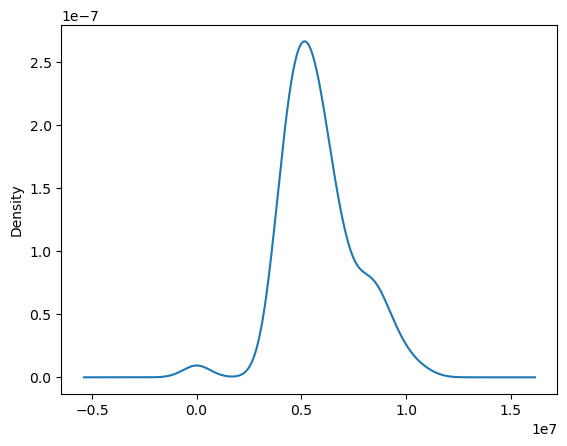

In [8]:
ollie_df['Revenue'].plot(kind='kde')

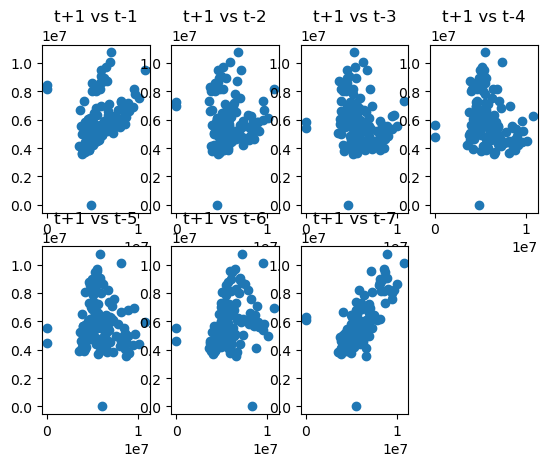

In [9]:
# Lag plots :
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

# Lag 21 days:
series = ollie_df['Revenue']

values = DataFrame(series.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns,axis = 1)
columns = ['t+1']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
    ax = pyplot.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

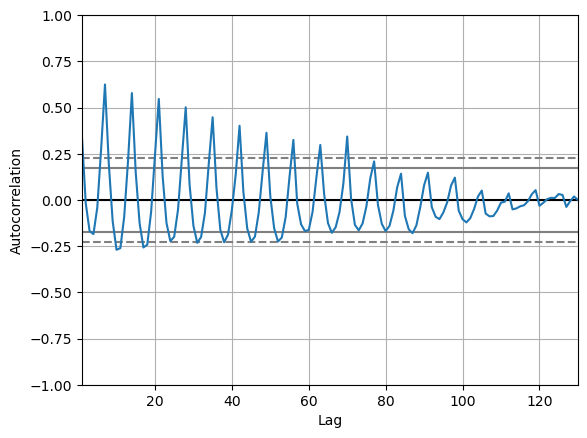

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

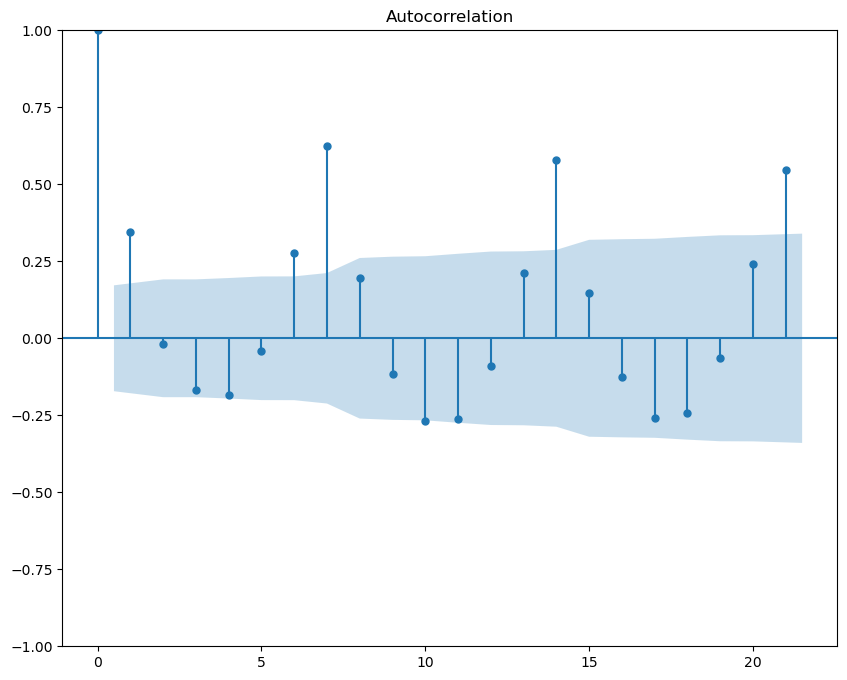

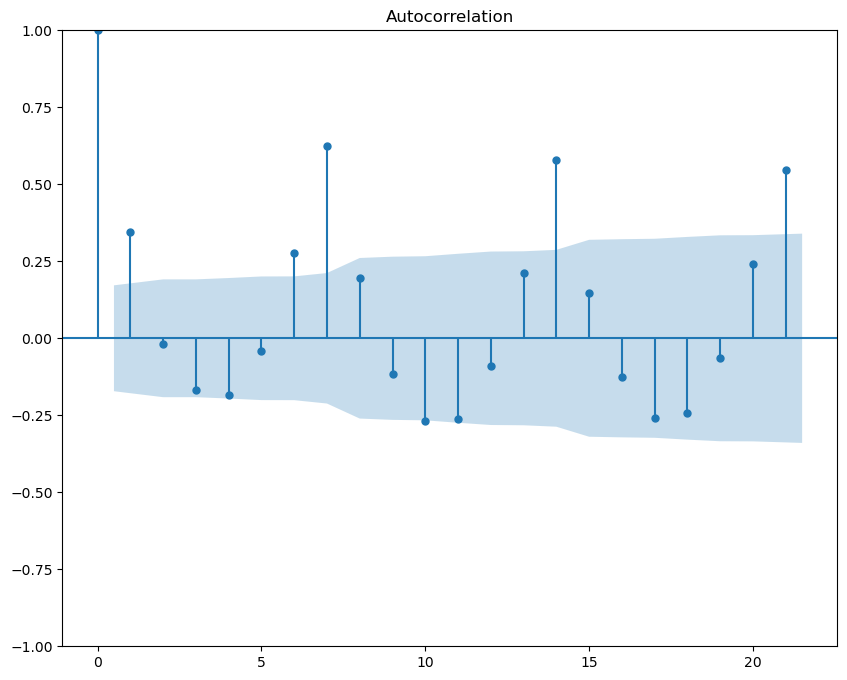

In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rc("figure",figsize = (10,8))
sm.graphics.tsa.plot_acf(series , lags = 21)

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

adftest = adfuller(series,maxlag = 9,autolag='t-stat',regression='ct')
print("ADF Test Results")
print("Null Hypothesis : The series has a unit root (non-stationary)")
print("ADF-Statistic", adftest[0])
print("p-value", adftest[1])
print("Number of lags", adftest[2])
print("Critical Values", adftest[4])

ADF Test Results
Null Hypothesis : The series has a unit root (non-stationary)
ADF-Statistic -3.380140968782021
p-value 0.054098316406654544
Number of lags 9
Critical Values {'1%': -4.036264302662037, '5%': -3.447730424768518, '10%': -3.1488821875}


In [13]:
sm.tsa.acf(series)

array([ 1.        ,  0.3447772 , -0.01771172, -0.16821923, -0.18489971,
       -0.04155915,  0.27568193,  0.62479786,  0.19460206, -0.11465091,
       -0.26974667, -0.26101331, -0.09119455,  0.21204001,  0.57814771,
        0.14776378, -0.12476175, -0.25733726, -0.2421526 , -0.06552329,
        0.23978904,  0.54656692])

In [14]:
holidays = pd.read_csv('generated_holidays.csv')
us_holidays_df =  pd.DataFrame(holidays[(holidays['year'] == 2024) & (holidays['country'] =='US' )])

In [15]:
df = ollie_df.copy()
prophet = Prophet(yearly_seasonality=True, holidays=us_holidays_df)
prophet_data = df.rename(columns = {'Revenue': 'y', 'Date': 'ds'})
prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])
prophet_predict.columns

14:41:22 - cmdstanpy - INFO - Chain [1] start processing
14:41:22 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Juneteenth National Independence Day',
       'Juneteenth National Independence Day_lower',
       'Juneteenth National Independence Day_upper', 'Labor Day',
       'Labor Day_lower', 'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'Thanksgiving', 'Thanksgiving_lower', 'Thanksgiving_upper',
       'Veterans Day', 'Veterans Day_lower', 'Veterans Day_upper',
       'Washington's Birthday', 'Washington's Birthday_lower',
       'Washington's Birthday_upper', 'additive

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

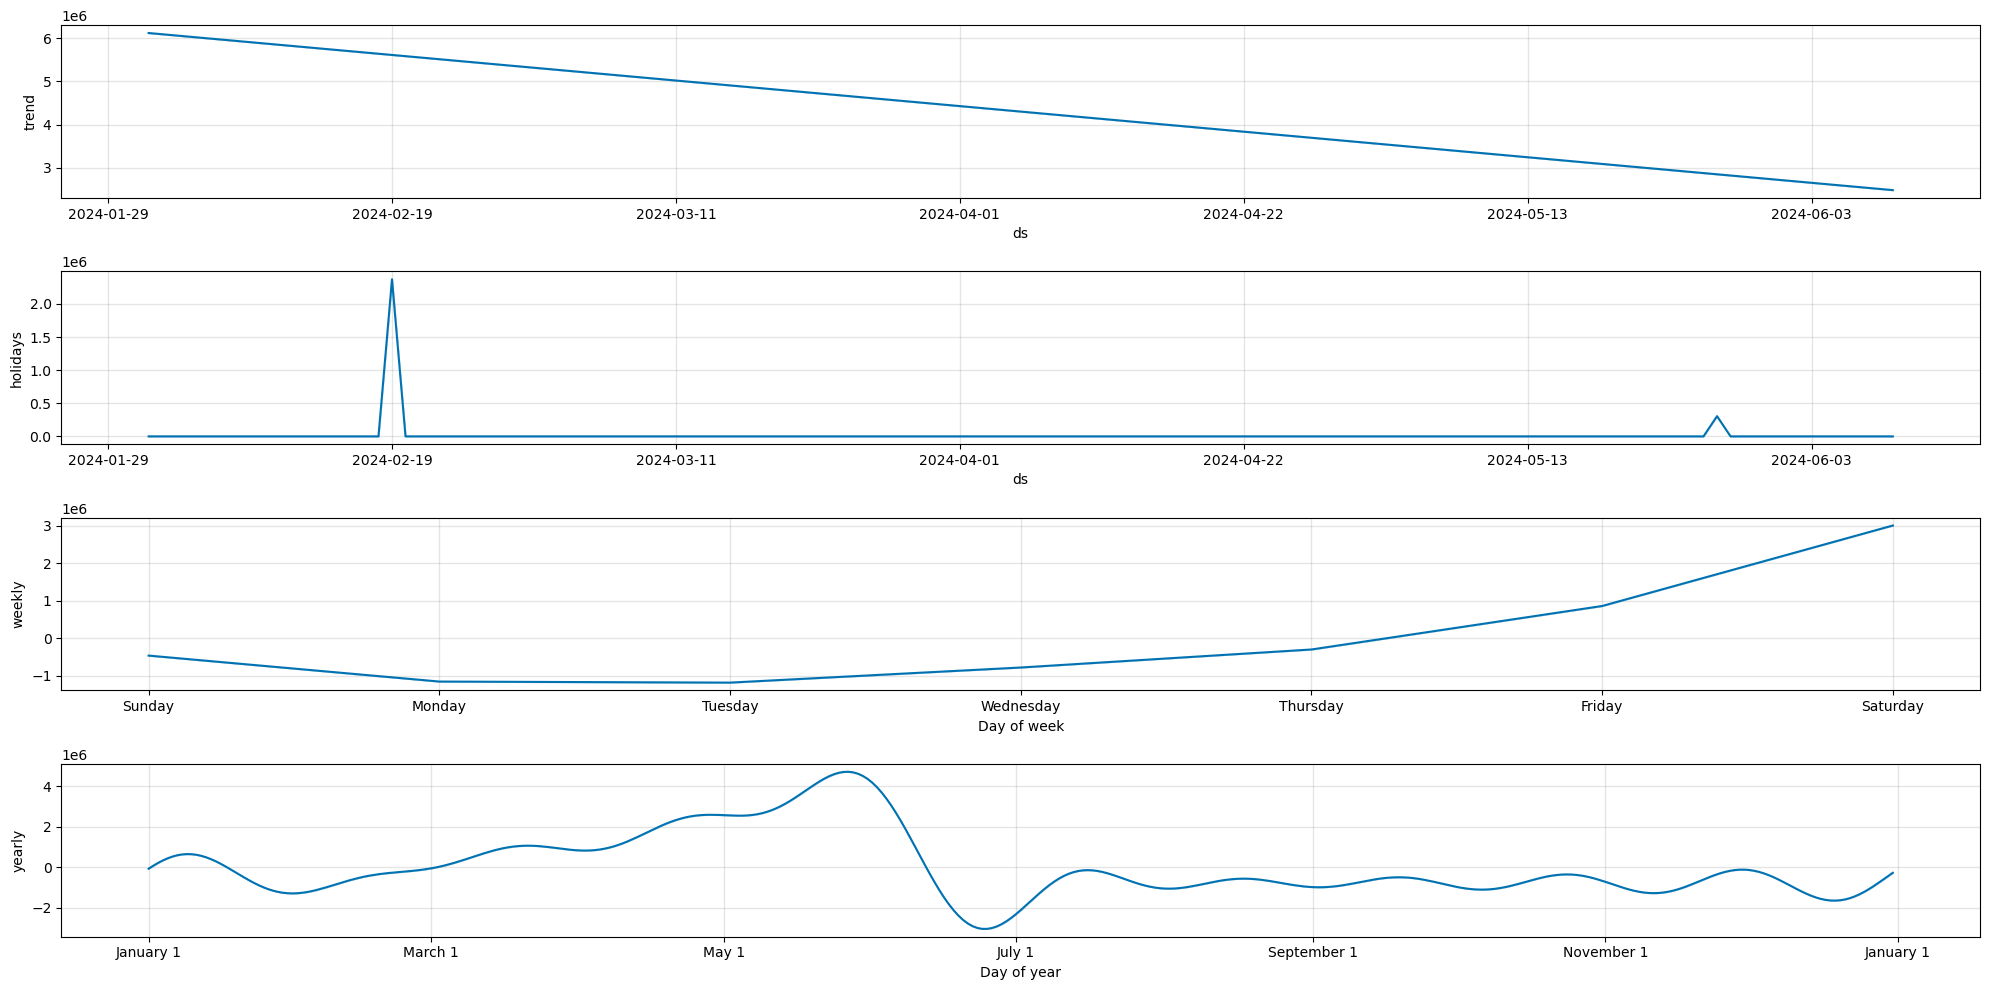

In [16]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [17]:
# Define Model parameters
X = df.drop(["META_I","TikTOk_I","Search_I","OLV_I","CTV_I","Display_I"],axis=1)
y = df["Revenue"]

spend_cols = [col for col in df.columns if '_S' in col]
X.head()

Date     Revenue        META_S  TikTok_S      Search_S  OLV_S  CTV_S  \
0  2024-02-01  4595511.00   4557.879999       0.0   5398.705116    0.0    0.0   
1  2024-02-02  5702035.90  12014.990000       0.0   9466.395597    0.0    0.0   
2  2024-02-03  8049132.14  13215.719998       0.0  11174.482018    0.0    0.0   
3  2024-02-04  5016905.50   7138.799998       0.0   6370.810997    0.0    0.0   
4  2024-02-05  3821767.81   4392.399999       0.0  10931.013103    0.0    0.0   

   Display_S  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [20]:
#As we do not know much more about the channels, we start with a simple heuristic:
#The channel contributions should be positive, so we can for example use a HalfNormal distribution as prior. 
#We need to set the sigma parameter per channel. The higher the sigma, the more “freedom” it has to fit the data.
#To specify sigma we can use the following point.
#We expect channels where we spend the most to have more attributed sales , before seeing the data. 
    
#How to incorporate this heuristic into the model? 
#To begin with, it is important to note that the DelayedSaturatedMMM class scales the target and input variables through 
# an MaxAbsScaler transformer from scikit-learn, its important to specify the priors in the scaled space (i.e. between 0 and 1).
#One way to do it is to use the spend share as the sigma parameter for the HalfNormal distribution.


spend_share = {
    'channel_name' : ['META','TikTok','Search','OLV','CTV','Display'],
    'Spend' : [ollie_df['META_S'].sum(),ollie_df['TikTok_S'].sum(),ollie_df['Search_S'].sum(),ollie_df['OLV_S'].sum(),ollie_df['CTV_S'].sum(),ollie_df['Display_S'].sum()]
    
}
 
# creating a Dataframe object 
df = pd.DataFrame(spend_share) 
spend_share = df.Spend / df.Spend.sum()
#Next, we specify the sigma parameter per channel:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
n_channels = 6
prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()
prior_sigma.tolist()

[4.255437609862844,
 0.06023425502466611,
 1.9583846269697458,
 2.0195376352752374,
 1.3342675526739445,
 0.32551876001539887]

In [33]:
custom_beta_channel_prior = {'intercept': {'dist': 'HalfNormal', 'kwargs': {'sigma': 0.05}},
                        'beta_channel': {'dist': 'LogNormal',
                                              "kwargs":{"mu":np.array([2,1,2,1,2,3]), "sigma": prior_sigma}},
                        'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
                        'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
                        'likelihood': {'dist': 'Normal',
                        'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 10}}}},
                         'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
                         'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
                            'intercept_tvp_kwargs': {'m': 20,
                                                  'L': None,
                                                  'eta_lam': 1,
                                                  'ls_mu': 100,
                                                  'ls_sigma': 2,
                                                  'cov_func': None}}

my_model_config = {**custom_beta_channel_prior}
my_model_config

{'intercept': {'dist': 'HalfNormal', 'kwargs': {'sigma': 0.05}},
 'beta_channel': {'dist': 'LogNormal',
  'kwargs': {'mu': array([2, 1, 2, 1, 2, 3]),
   'sigma': array([4.25543761, 0.06023426, 1.95838463, 2.01953764, 1.33426755,
          0.32551876])}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 10}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
 'intercept_tvp_kwargs': {'m': 20,
  'L': None,
  'eta_lam': 1,
  'ls_mu': 100,
  'ls_sigma': 2,
  'cov_func': None}}

In [34]:
ollies_mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    target_column='Revenue',
    date_column='Date',
    validate_data = True,
    channel_columns=spend_cols,
    #control_columns = ['google_trends'],
    adstock_max_lag = 10, 
    yearly_seasonality = 2,
    time_varying_intercept = False
)
ollies_mmm.model_config


{'intercept': {'dist': 'HalfNormal', 'kwargs': {'sigma': 0.05}},
 'beta_channel': {'dist': 'LogNormal',
  'kwargs': {'mu': array([2, 1, 2, 1, 2, 3]),
   'sigma': array([4.25543761, 0.06023426, 1.95838463, 2.01953764, 1.33426755,
          0.32551876])}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 10}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
 'intercept_tvp_kwargs': {'m': 20,
  'L': None,
  'eta_lam': 1,
  'ls_mu': 100,
  'ls_sigma': 2,
  'cov_func': None}}

In [35]:
idata = ollies_mmm.fit(X,y, target_accept=0.95, chains=4, random_seed=43)

/opt/conda/lib/python3.10/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pymc/model/core.py:988: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_fourier, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [36]:
ollies_mmm.fit_result

<xarray.Dataset> Size: 96MB
Dimensions:                    (chain: 4, draw: 1000, channel: 6, date: 130,
                                fourier_mode: 4)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * channel                    (channel) <U9 216B 'META_S' ... 'Display_S'
  * date                       (date) object 1kB 2024-02-01 ... 2024-06-09
  * fourier_mode               (fourier_mode) <U11 176B 'sin_order_1' ... 'co...
Data variables:
    alpha                      (chain, draw, channel) float64 192kB 0.1173 .....
    beta_channel               (chain, draw, channel) float64 192kB 0.5025 .....
    channel_adstock            (chain, draw, date, channel) float64 25MB 0.07...
    channel_adstock_saturated  (chain, draw, date, channel) float64 25MB 0.08...
    channel_contributions      (chain, draw, date, channel) float64 25MB 0.04...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 17MB ...
    gamma_fourier              (chain, draw, fourier_mode) float64 128kB 0.37...
    intercept                  (chain, draw) float64 32kB 0.05389 ... 0.03493
    lam                        (chain, draw, channel) float64 192kB 2.434 ......
    likelihood_sigma           (chain, draw) float64 32kB 0.1259 ... 0.1379
    mu                         (chain, draw, date) float64 4MB 0.4404 ... 0.479
Attributes:
    created_at:                 2024-06-12T15:04:45.104625+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.0
    sampling_time:              51.70177936553955
    tuning_steps:               1000

/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


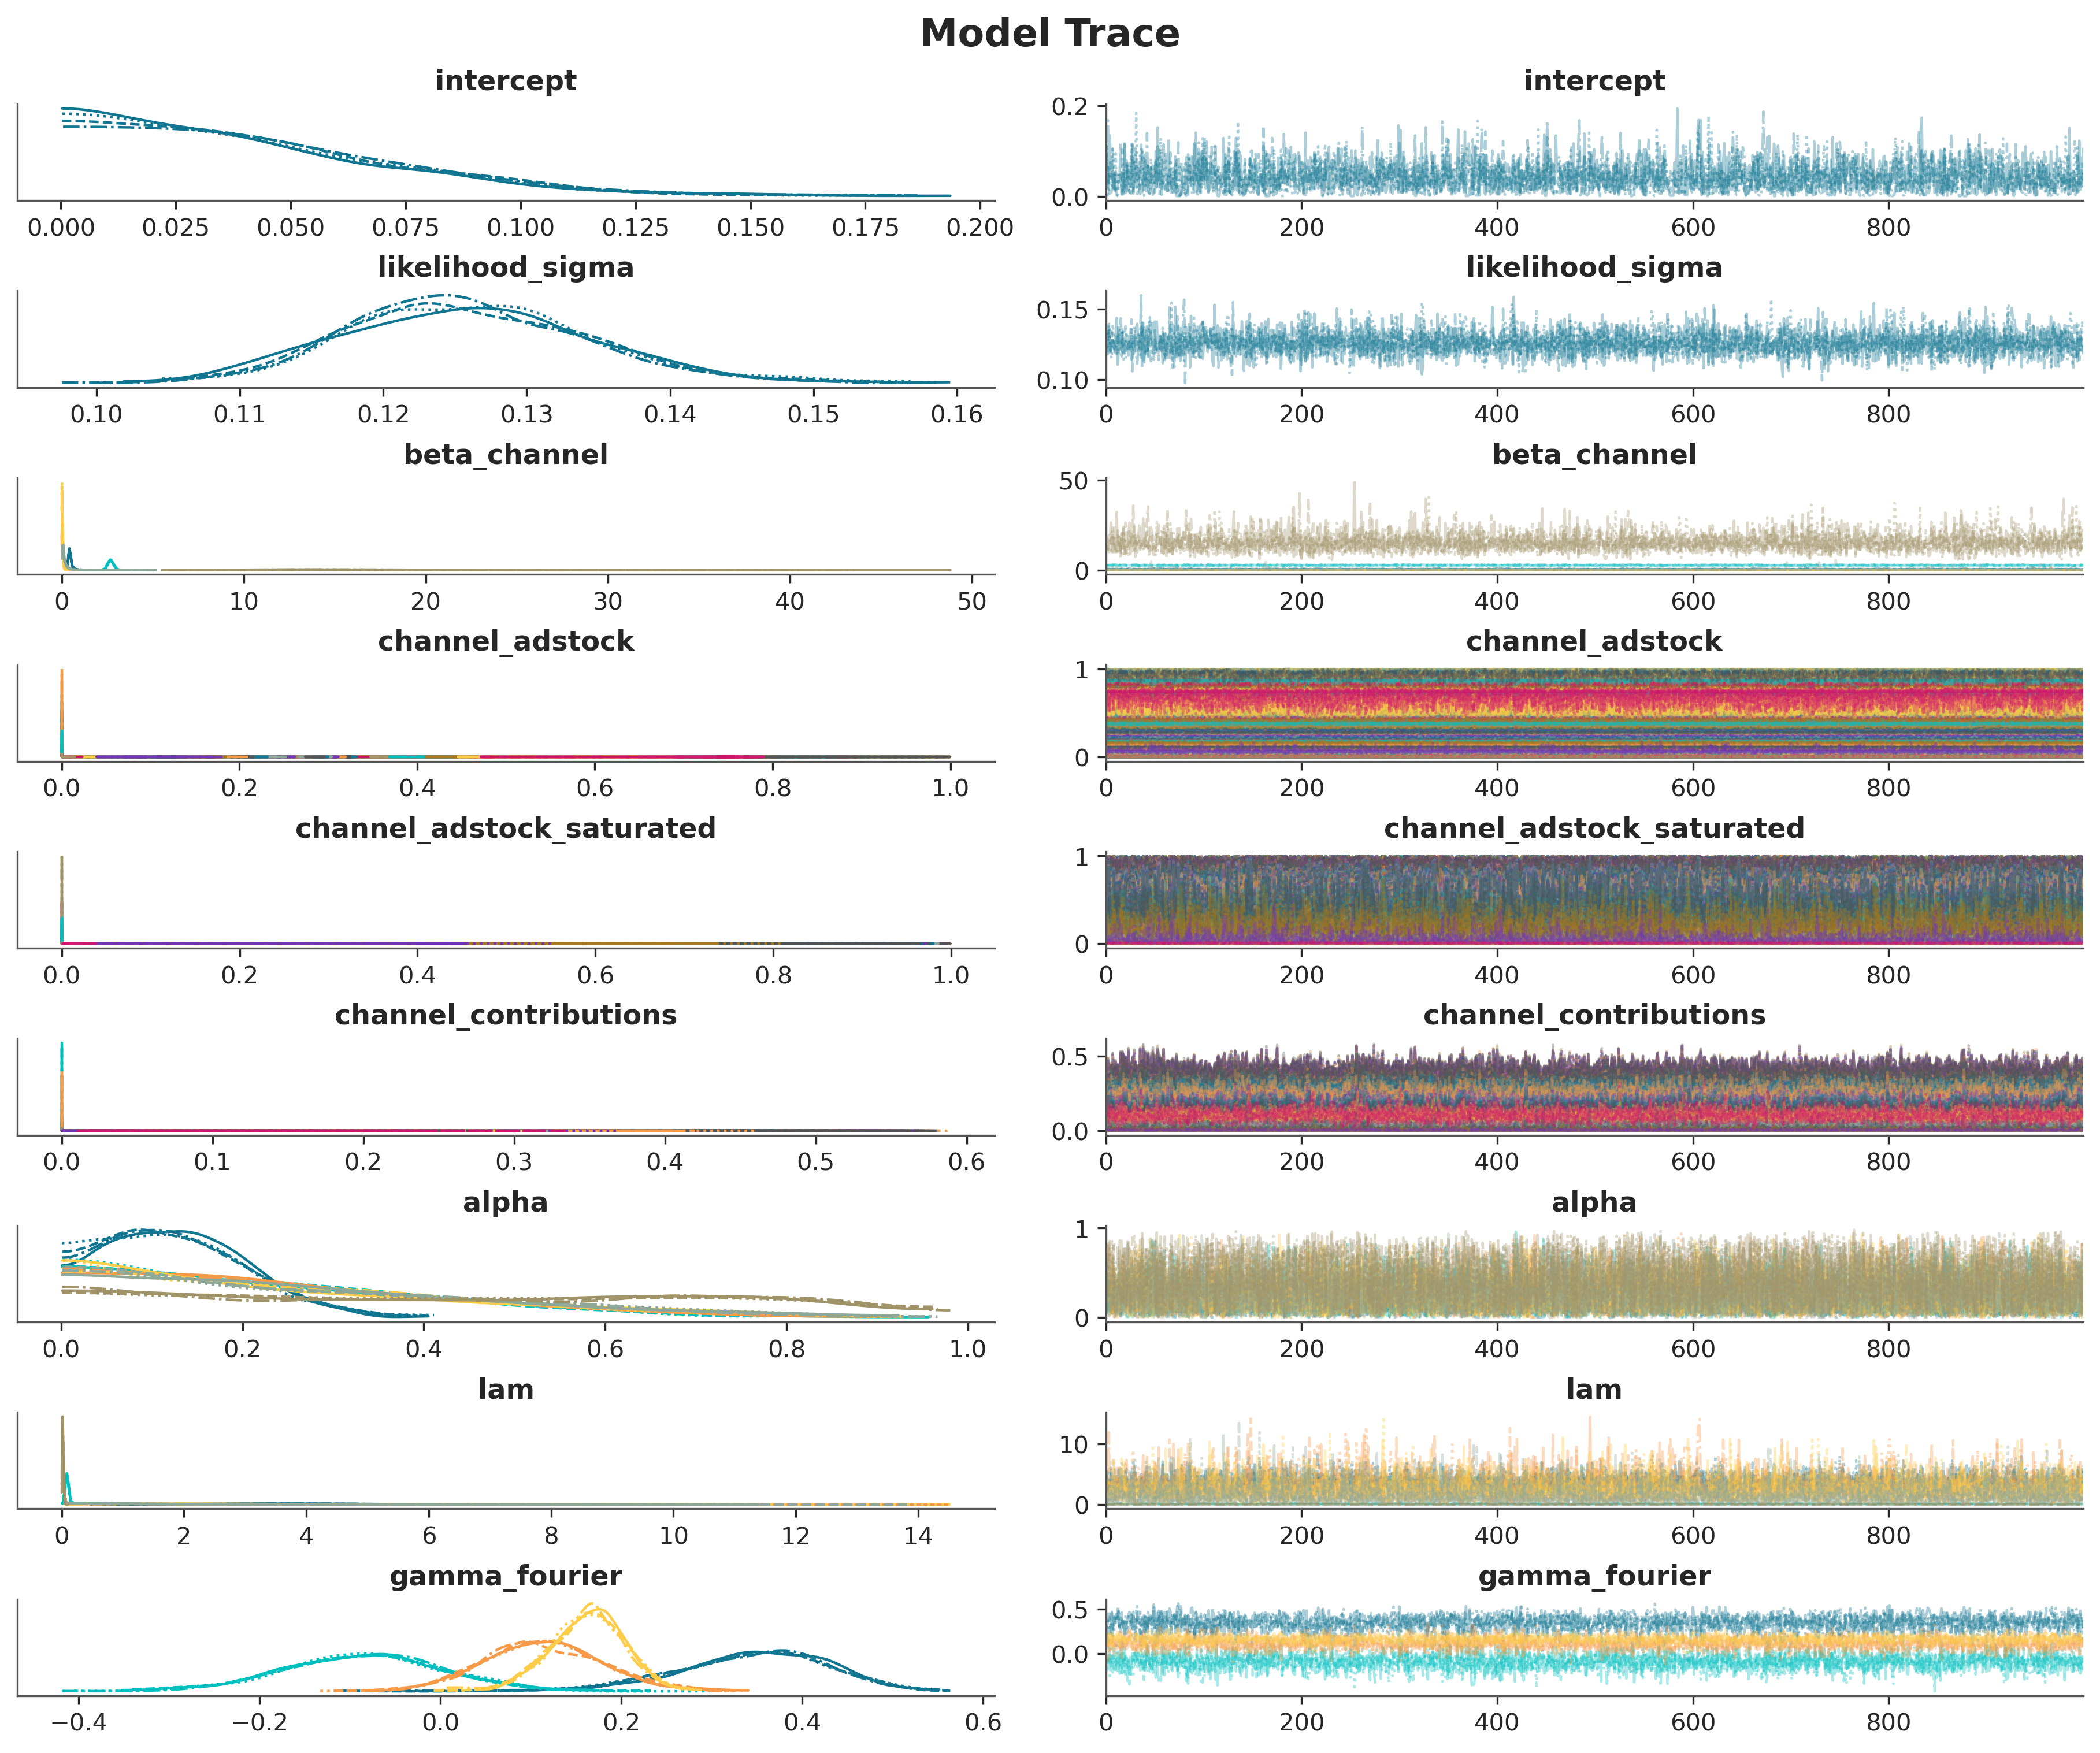

In [37]:
params_plt = az.plot_trace(
    data=ollies_mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "channel_adstock",
        "channel_adstock_saturated",
        "channel_contributions",
        "alpha",
        "lam",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

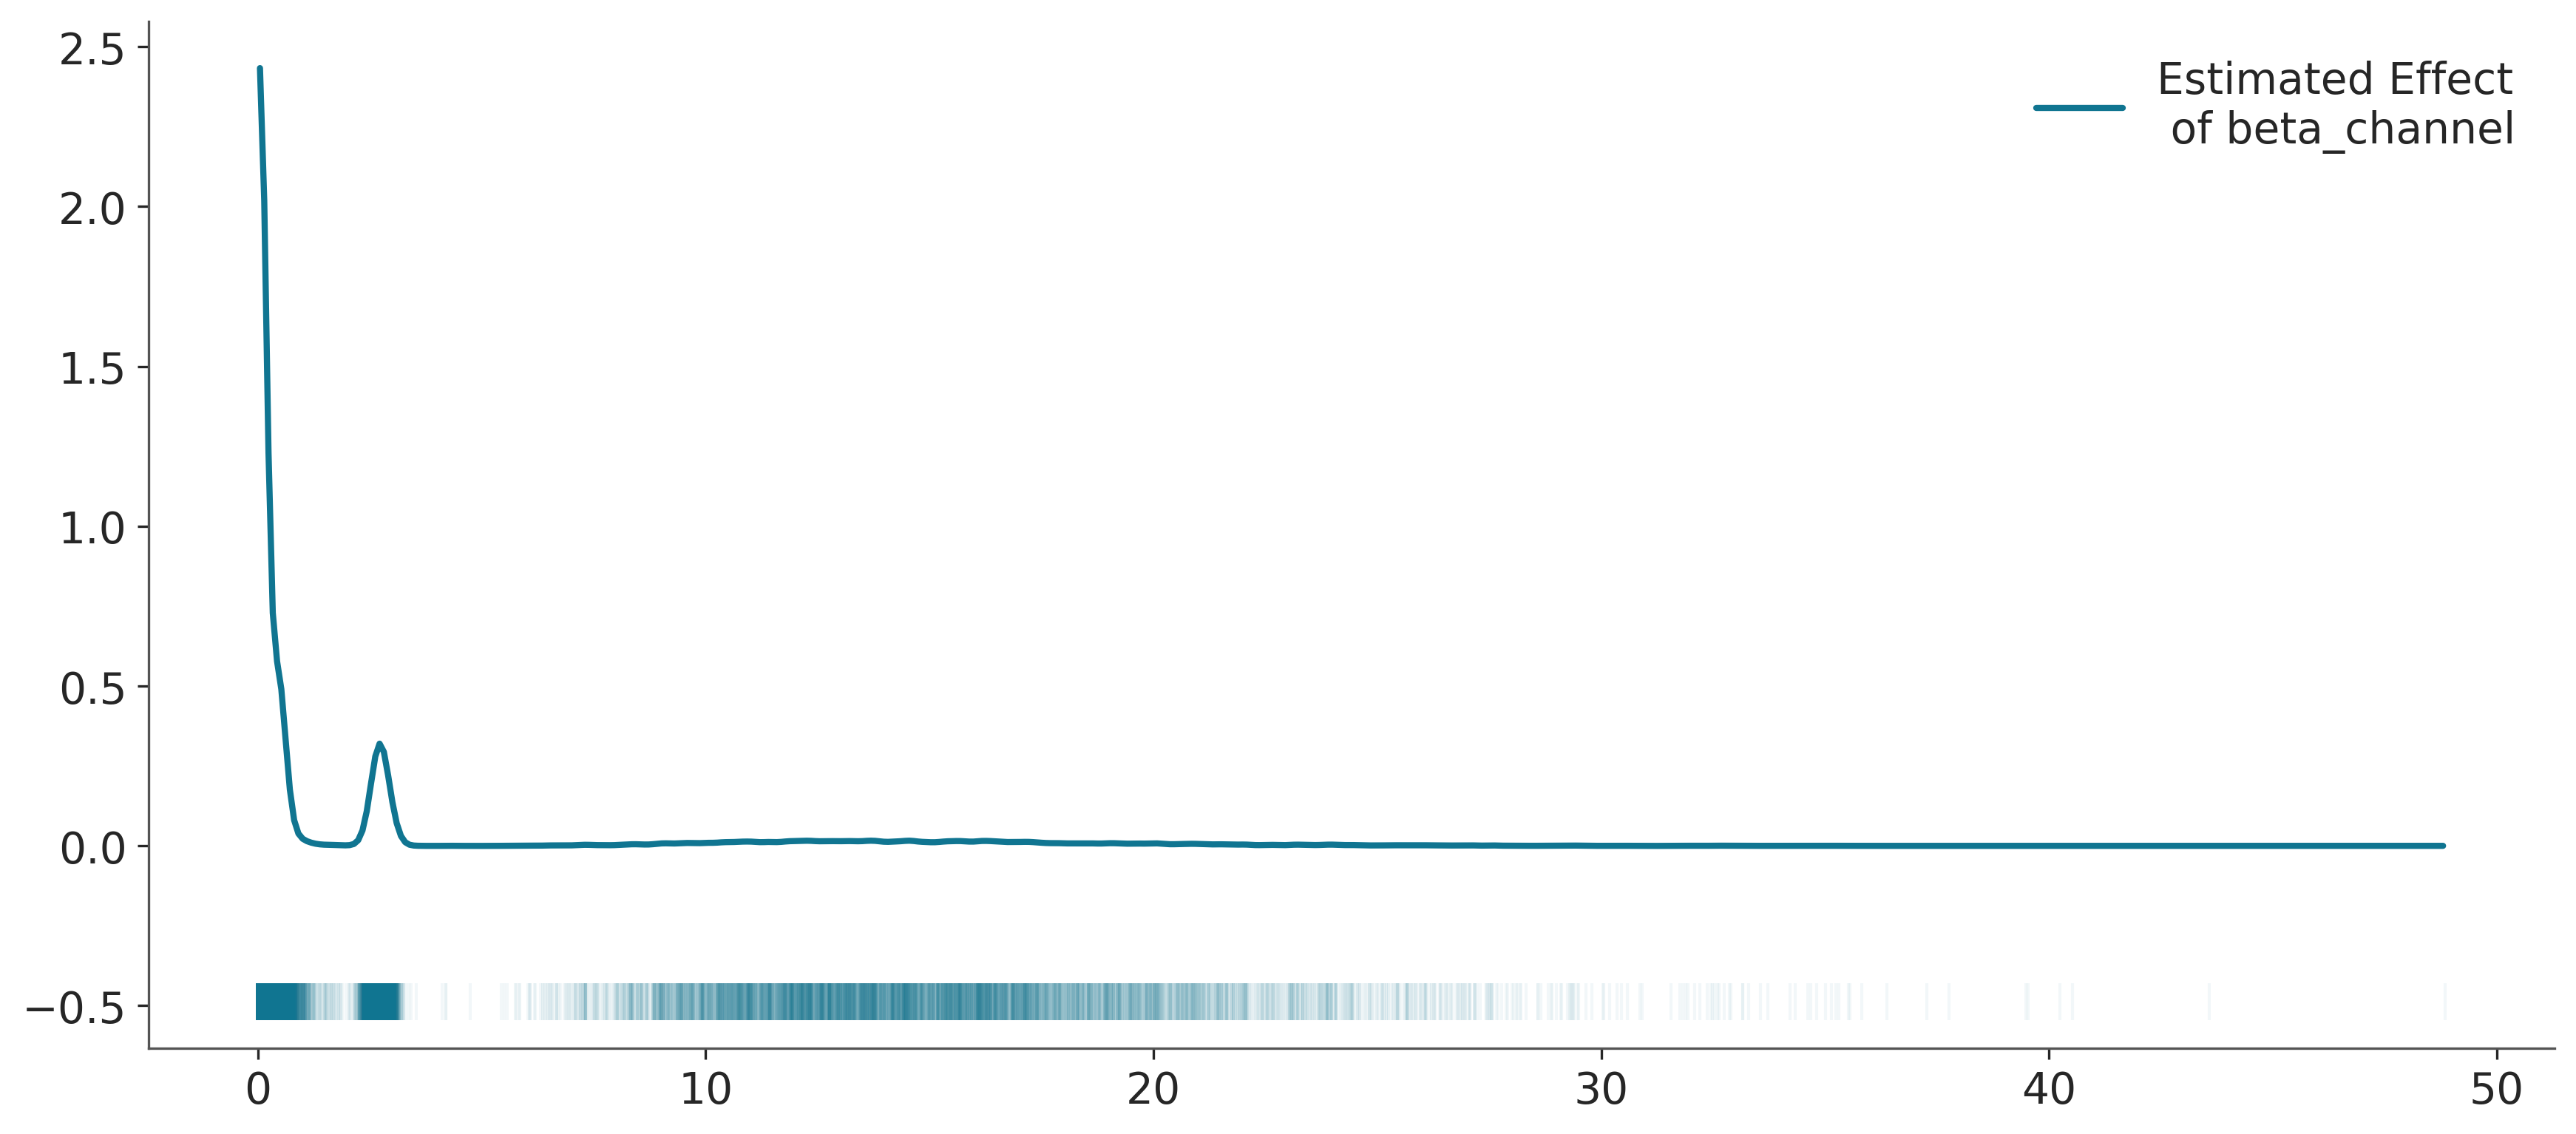

In [38]:
az.style.use("arviz-doc")

y_hat = np.concatenate(idata.posterior["beta_channel"].values)

az.plot_kde(
    y_hat,
    label="Estimated Effect\n of beta_channel",
    rug=True,
    plot_kwargs={"linewidth": 2},
    rug_kwargs={"alpha": 0.05},
)

plt.show()

In [39]:
from sklearn.metrics import r2_score

y_in_sample = ollies_mmm.predict(X, extend_idata=True)

y_true = y
y_pred = y_in_sample

print(f"RMSE: {np.sqrt(np.mean((y_true-y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true-y_pred) / y_true))}")

def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

print(f"NRMSE: {nrmse(y_true, y_pred)}")
print(f"R^2: {r2_score(y_true, y_pred)}")

Sampling: [y]


Output()

RMSE: 1293754.6096774705
MAPE: inf
NRMSE: 0.12021544095752369
R^2: 0.43896969528458163


In [ ]:
ollies_mmm.plot_components_contributions();

In [ ]:
# Waterfall decomposition:

def plot_waterfall_components_decomposition(
        model,
        original_scale: bool = True,
        figsize: tuple[int, int] = (14, 7),
        **kwargs,
    ) -> plt.Figure:
        """
        This function creates a waterfall plot. The plot shows the decomposition of the target into its components.

        Parameters
        ----------
        original_scale : bool, optional
            If True, the contributions are plotted in the original scale of the target.
        figsize : Tuple, optional
            The size of the figure. The default is (14, 7).
        **kwargs
            Additional keyword arguments to pass to the matplotlib `subplots` function.

        Returns
        -------
        fig : matplotlib.figure.Figure
            The matplotlib figure object.
        """

        dataframe = model.compute_mean_contributions_over_time(
            original_scale=original_scale
        )

        dataframe = model._process_decomposition_components(data=dataframe)
        total_contribution = dataframe["contribution"].sum()

        fig, ax = plt.subplots(figsize=figsize, layout="constrained", **kwargs)

        cumulative_contribution = 0

        for index, row in dataframe.iterrows():
            color = "C0" if row["contribution"] >= 0 else "C3"

            bar_start = (
                cumulative_contribution + row["contribution"]
                if row["contribution"] < 0
                else cumulative_contribution
            )
            ax.barh(
                row["component"],
                row["contribution"],
                left=bar_start,
                color=color,
                alpha=0.5,
            )

            if row["contribution"] > 0:
                cumulative_contribution += row["contribution"]

            label_pos = bar_start + (row["contribution"] / 2)

            if row["contribution"] < 0:
                label_pos = bar_start - (row["contribution"] / 2)

            ax.text(
                label_pos,
                index,
                f"{row['contribution']:,.0f}\n({row['percentage']:.1f}%)",
                ha="center",
                va="center",
                color="black",
                fontsize=10,
            )

        ax.set_title("Response Decomposition Waterfall by Components")
        ax.set_xlabel("Cumulative Contribution")
        ax.set_ylabel("Components")

        xticks = np.linspace(0, total_contribution, num=11)
        xticklabels = [f"{(x/total_contribution)*100:.0f}%" for x in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)

        ax.set_yticks(np.arange(len(dataframe)))
        ax.set_yticklabels(dataframe["component"])

        return fig
    
plot_waterfall_components_decomposition(ollies_mmm);

In [ ]:
az.summary(
    data=ollies_mmm.fit_result,
    var_names=[
        "beta_channel",
        "alpha",
        "lam"
    ],
)

In [ ]:
idata

In [ ]:
pm.gelman_rubin(ollies_mmm)

In [ ]:
channel_betas = ollies_mmm.idata.posterior.beta_channel.mean(dim=['chain']).mean(axis=0)
channel_betas

In [ ]:
channel_contributions = ollies_mmm.idata.posterior.channel_contributions.mean(dim=['chain','draw']).mean(axis=0)
channel_contributions

In [ ]:
channel_adstock = ollies_mmm.idata.posterior.channel_adstock.mean(dim=['chain', 'draw']).mean(axis=0)
channel_adstock

In [ ]:
channel_adstock_saturated = ollies_mmm.idata.posterior.channel_adstock_saturated.mean(dim=['chain', 'draw']).mean(axis=0)
channel_adstock_saturated

In [ ]:
ollies_mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12)

In [ ]:
ollies_mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12, absolute_xrange=True);

In [ ]:
ollies_mmm.plot_direct_contribution_curves(show_fit = True,same_axes=True)

In [ ]:
ollies_mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))